In [4]:
# 库文件
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
# 设置中文字体
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)  # 替换为你的中文字体文件路径
import sys
sys.path.append(r"C:\Users\haokw\Documents\GitHub\gaolu\MPC\高炉")
from base import    double_control_predict_result,\
                    gaolu_predict_raw,\
                    data_tranform_plot,\
                    get_y_aim_data,\
                    generate_yr,\
                    replace_outliers_with_weighted_diff

from base import MyRNNModel,CustomPredictor_double


NameError: name 'model' is not defined

In [36]:
# 读取Excel文件
excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据\\高频\\1h_mean\\1h_mean.xlsx'
df_sheet_yuansu = pd.read_excel(excel_path, sheet_name='原始输出') 
# df_sheet_yuansu = pd.read_excel(excel_path, sheet_name='剔除直线输出') 
print(df_sheet_yuansu.info())
print(df_sheet_yuansu.columns)

excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据\\高频\\1h_mean\\1h_mean.xlsx'
df_sheet_params = pd.read_excel(excel_path, sheet_name='1h_mean') 

print(df_sheet_params.info())
print(df_sheet_params.columns)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7398 entries, 0 to 7397
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   时间戳h    7398 non-null   int64  
 1   时间戳10m  7398 non-null   int64  
 2   SI      7398 non-null   float64
 3   铁口1温度   7398 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 231.3 KB
None
Index(['时间戳h', '时间戳10m', 'SI', '铁口1温度'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377 entries, 0 to 7376
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   主参数时间戳2  7377 non-null   int64  
 1   时间戳h     7377 non-null   int64  
 2   富氧流量     7377 non-null   float64
 3   冷风流量     7377 non-null   float64
 4   热风压力     7377 non-null   float64
 5   冷风温度     7377 non-null   float64
 6   热风温度     7377 non-null   float64
 7   鼓风湿度     7377 non-null   float64
 8   设定喷煤量    7377 non-null   float64
dtypes: float64(7), int64(2)
memor

In [37]:
import pandas as pd

# 假设 df 是你的 DataFrame

# 检查 DataFrame 中是否包含 NaN 值
contains_nan = df_sheet_yuansu.isna().any().any()

if contains_nan:
    print("数据包含 NaN 值")
else:
    print("数据不包含 NaN 值")
    # 检查 DataFrame 中是否包含 NaN 值
contains_nan = df_sheet_params.isna().any().any()

if contains_nan:
    print("数据包含 NaN 值")
else:
    print("数据不包含 NaN 值")


数据不包含 NaN 值
数据不包含 NaN 值


In [38]:
# 定义输入输出参数
input_term = ['富氧流量', '冷风流量', '热风压力', '冷风温度', '热风温度', '鼓风湿度', '设定喷煤量']
output_term = ['铁口1温度', 'SI']
time_term= '时间戳h'


C:\Users\haokw\AppData\Local\Temp\ipykernel_25608\1726023440.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[idx] = interpolated_value
C:\Users\haokw\AppData\Local\Temp\ipykernel_25608\1726023440.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[idx] = interpolated_value
C:\Users\haokw\AppData\Local\Temp\ipykernel_25608\1726023440.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[idx] = interpolated_value
C:\Users\haok

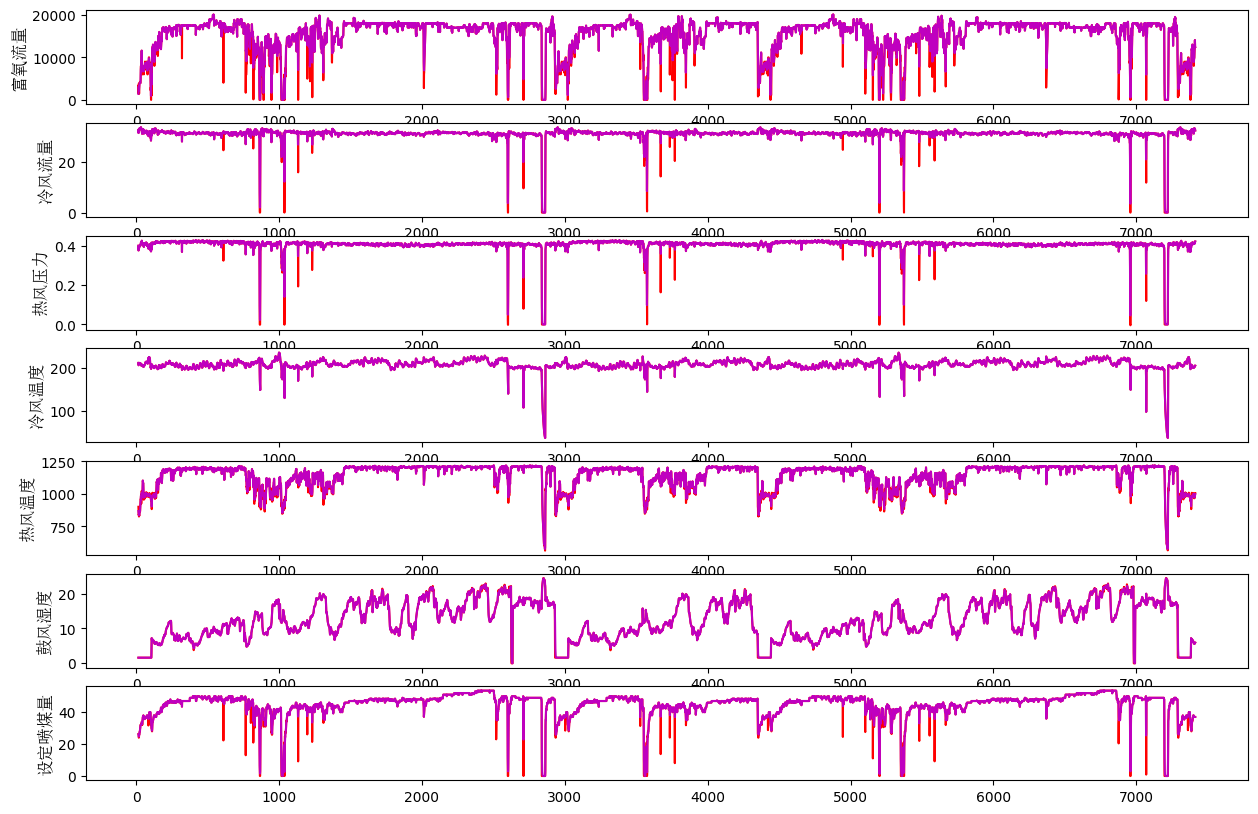

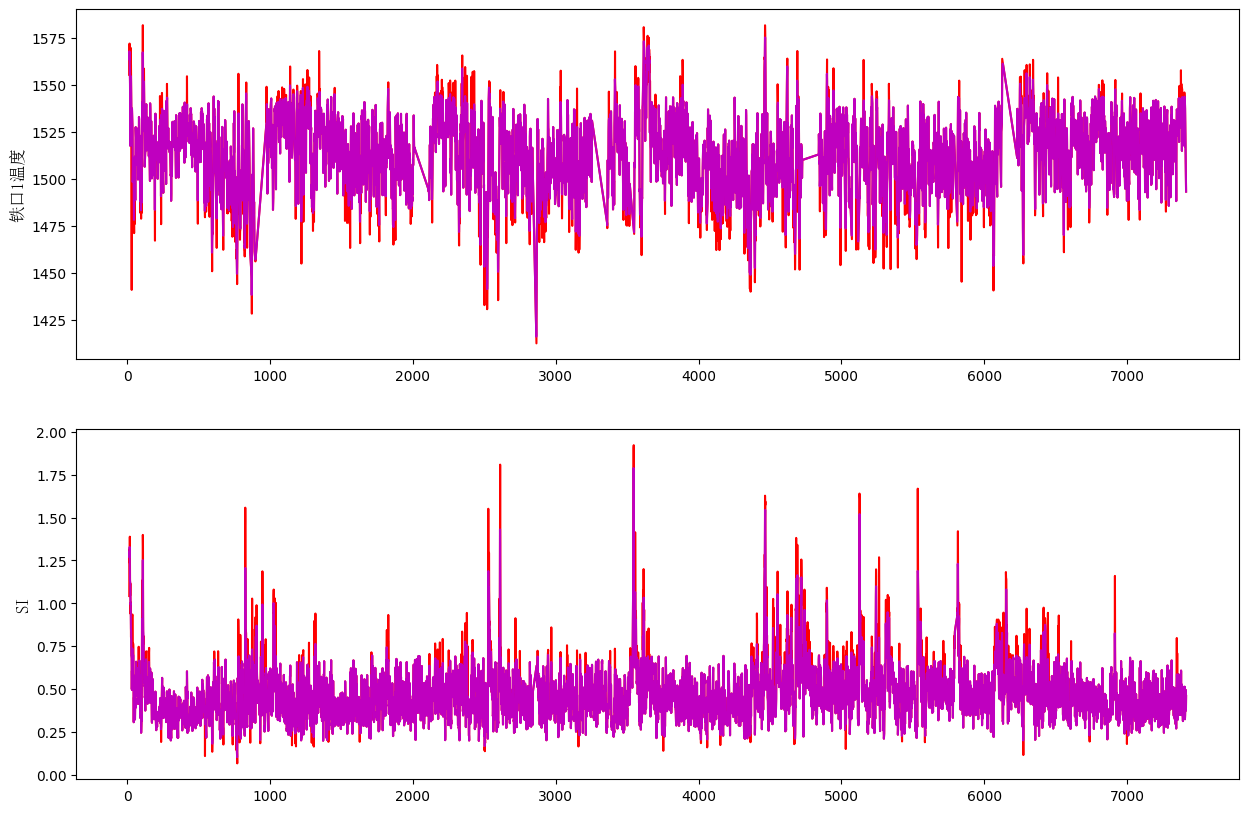

In [39]:
# 异常数据处理-处理前后对比
# 创建数据框副本以避免修改原始数据
df_sheet_yuansu_process = df_sheet_yuansu.copy()
df_sheet_params_process = df_sheet_params.copy()
# 定义一个函数，用前后两个值的差值按照距离进行加权替换异常值
def replace_outliers_with_weighted_diff(x, y):
    # 计算列的中位数
    median_value = y.median()
    # 检测异常值的索引
    outliers_index = (y - median_value).abs() > 1.5 * y.std()  # 使用标准差作为阈值
    
    # 遍历异常值的索引
    for idx in outliers_index[outliers_index].index:
        # 获取异常值前一个和后一个值的索引
        prev_idx = idx - 1 if idx - 1 >= 0 else idx
        next_idx = idx + 1 if idx + 1 < len(y) else idx
        # 计算当前 x 与前后两个 x 的距离
        dist_prev = abs(x[idx] - x[prev_idx])
        dist_next = abs(x[next_idx] - x[idx])
        total_dist = dist_prev + dist_next
        # 计算权重
        weight_prev = dist_next / total_dist
        weight_next = dist_prev / total_dist
        # 计算前后两个值的差值
        diff = y[next_idx] - y[prev_idx]
        # 根据权重进行插值
        interpolated_value = y[prev_idx] + weight_prev * diff
        # 用插值结果替代异常值
        y[idx] = interpolated_value

# 画出数据
def plot_subplot(data_x,data_y_yuan,data_y,column):
    plt.plot(data_x,data_y_yuan,'r-')
    plt.plot(data_x,data_y,'m-')
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签
    # 使用中文标签


# 对指定列应用替代异常值的函数
# 对指定列应用替代异常值的函数
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[0]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[1]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[2]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[4]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[5]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[6]])

replace_outliers_with_weighted_diff(df_sheet_yuansu_process[time_term], df_sheet_yuansu_process[output_term[0]])
replace_outliers_with_weighted_diff(df_sheet_yuansu_process[time_term], df_sheet_yuansu_process[output_term[1]])

plt.figure(figsize=(15, 10))
for idx, column in enumerate(input_term):
    plt.subplot(len(input_term), 1, idx+1)
    plot_subplot(df_sheet_params_process[time_term].values,df_sheet_params[column].values,df_sheet_params_process[column].values,column)

plt.figure(figsize=(15, 10))
for idx, column in enumerate(output_term):
    plt.subplot(len(output_term), 1, idx+1)
    plot_subplot(df_sheet_yuansu_process[time_term].values,df_sheet_yuansu[column].values,df_sheet_yuansu_process[column].values,column)




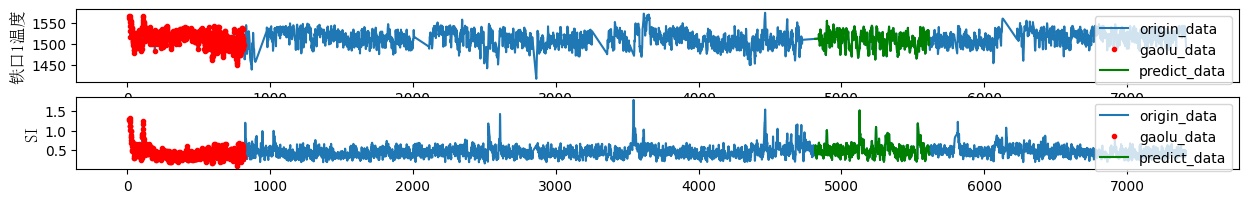

In [42]:
# 画出选取的数据
def plot_subplot(data_x,data_y,column,index_predict,index_gaolu):
    plt.plot(data_x,data_y,'-', label='origin_data')
    plt.plot(data_x[index_gaolu],data_y[index_gaolu],'r.', label='gaolu_data')
    plt.plot(data_x[index_predict],data_y[index_predict],'g-', label='predict_data')
    plt.legend()
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签



length1 = 800
start1 = 0
length2 = 800
start2 = 4800


index_gaolu   = range(start1, start1+length1+1, 1)
index_predict     = range(start2, start2+length2+1, 1)
# index = range(1, 7572, 1)


plt.figure(figsize=(15, 10))
for idx, column in enumerate(output_term):
    plt.subplot(len(input_term+output_term), 1, idx+1)
    plot_subplot(df_sheet_yuansu_process[time_term].values,df_sheet_yuansu_process[column].values,column,index_predict,index_gaolu)


In [43]:
# 数据归一化、逆归一化
from sklearn.preprocessing import MinMaxScaler

# 将数据存储为字典，每个键对应一列数据
original_data_dict = {
    input_term[0]:   df_sheet_params_process[input_term[0]].values,
    input_term[1]:   df_sheet_params_process[input_term[1]].values,
    input_term[2]:   df_sheet_params_process[input_term[2]].values,
    input_term[3]:   df_sheet_params_process[input_term[3]].values,
    input_term[4]:   df_sheet_params_process[input_term[4]].values,
    input_term[5]:   df_sheet_params_process[input_term[5]].values,
    input_term[6]:   df_sheet_params_process[input_term[6]].values,
    output_term[0]:  df_sheet_yuansu_process[output_term[0]].values,
    output_term[1]:  df_sheet_yuansu_process[output_term[1]].values
}

# 初始化缩放器
scalers = {}

# 进行拟合
for column, data in original_data_dict.items():
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data.reshape(-1, 1))  # 保证数据是列向量
    scalers[column] = scaler

# 进行归一化
normalized_data_dict = {}
for column, scaler in scalers.items():
    normalized_data_dict[column] = scaler.transform(original_data_dict[column].reshape(-1, 1)).flatten()

# 进行反归一化
original_data_dict = {}
for column, scaler in scalers.items():
    original_data_dict[column] = scaler.inverse_transform(normalized_data_dict[column].reshape(-1, 1)).flatten()


In [44]:
# # 标定归一化前后数据
# data_point = np.array([1500]).reshape(-1, 1)
# data1 = scalers[output_term[0]].transform(data_point).flatten()

# data_point = np.array(data1).reshape(-1, 1)
# data2 = scalers[output_term[0]].inverse_transform(data_point).flatten()

# data_point = np.array([1510]).reshape(-1, 1)
# data3 = scalers[output_term[0]].transform(data_point).flatten()

# data_point = np.array(data3).reshape(-1, 1)
# data4 = scalers[output_term[0]].inverse_transform(data_point).flatten()

# print(data1)
# print(data2)
# print(data3)
# print(data4)
# d_temp = (data3-data1)/(data4-data2)
# print('每摄氏度的输出差：',d_temp)



# data_point = np.array([0.50]).reshape(-1, 1)
# data1 = scalers[output_term[1]].transform(data_point).flatten()

# data_point = np.array(data1).reshape(-1, 1)
# data2 = scalers[output_term[1]].inverse_transform(data_point).flatten()

# data_point = np.array([0.60]).reshape(-1, 1)
# data3 = scalers[output_term[1]].transform(data_point).flatten()

# data_point = np.array(data3).reshape(-1, 1)
# data4 = scalers[output_term[1]].inverse_transform(data_point).flatten()

# print(data1)
# print(data2)
# print(data3)
# print(data4)
# d_yuansu = (data3-data1)/(data4-data2)
# print('每0.01浓度的输出差：',(data3-data1))


In [45]:
isShuffle = True
# isShuffle = False


In [46]:
time_steps = 2


In [47]:
# 组合训练数据--拆分训练、测试集
test_size = 0.15
val_size = test_size
train_size = 1-val_size-test_size
# 定义时间步数和特征数


def make_data(u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data,y1_data,y2_data,index_fanwei):
    # 假设您有六个时间序列数据
    # u1_data, u2_data, u3_data, u4_data, y1_data, y2_data 是形状为 (800, 1) 的 NumPy 数组

    # 堆叠输入和输出数据
    X = np.column_stack((u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data))
    y = np.column_stack((y1_data, y2_data))
    # print('X',X.shape)



    # 创建空数组用于存储新的输入和输出数据
    X_modified = []
    y_modified = []
    
    # 生成新的输入和输出数据
    for i in range(3,len(y1_data)):
        if i in index_fanwei:
            # print(i)
            # print(df_sheet_yuansu[time_term][i])
            yuansu_time = df_sheet_yuansu[time_term][i]
            closest_10 = df_sheet_params[df_sheet_params[time_term] < yuansu_time].nlargest(time_steps, time_term)
            # print(closest_10)
            # closest_10 = closest_10.sort_values(by=time_term)
            index = closest_10.index
            # print(index)
            # print(closest_10)
            # print(closest_10.iloc[-1][time_term])
            if closest_10.iloc[-1][time_term] < yuansu_time - time_steps:
                print(i,yuansu_time,'errloss')
            
            else:
                
                # 构成    
                # X = np.column_stack((u1_data  [1:-1], u2_data  [1:-1], u3_data  [1:-1], u4_data  [1:-1], u5_data  [1:-1], u6_data  [1:-1], u7_data  [1:-1],
                #                      u1_data_1[1:-1], u2_data_1[1:-1], u3_data_1[1:-1], u4_data_1[1:-1], u5_data_1[1:-1], u6_data_1[1:-1], u7_data_1[1:-1],
                #                      y1_data  [1:-1], y2_data  [1:-1])
                # print(X[index, :])
                new_x_sample = np.concatenate([X[i, :] for i in index],axis=0)
                # print(new_x_sample)
                y_last = y[i-1, :]
                # print(y_last)
                new_x_sample = np.concatenate([new_x_sample,y_last],axis=0)
                # print(new_x_sample)



                y_sample = y[i, :]  

                X_modified.append(new_x_sample)
                y_modified.append(y_sample)
                print(i,yuansu_time,index[0],index[-1], end='\r')
                

        
    # 将列表转换为 NumPy 数组
    X_modified = np.array(X_modified)
    y_modified = np.array(y_modified)
    X_reshaped = X_modified.reshape((X_modified.shape[0], 1, X_modified.shape[1]))

    # 打印新数据的形状
    print("Modified Input Shape:", X_reshaped.shape)
    print("Modified Output Shape:", y_modified.shape)


    X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_modified, 
                                                        test_size=test_size, 
                                                        random_state=42, 
                                                        shuffle=isShuffle)

    # 将剩余的70%训练数据再次拆分成训练数据和验证数据（20%验证数据，50%训练数据）
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                        test_size=val_size/(train_size+val_size), 
                                                        random_state=42, 
                                                        shuffle=isShuffle)

    print('训练数量：',X_train.shape,y_train.shape)
    print('验证数量：',X_val.shape,y_val.shape)
    print('测试数量：',X_test.shape,y_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test


In [48]:
# 高炉模型列数据
u1_data = normalized_data_dict[input_term[0]]
u2_data = normalized_data_dict[input_term[1]]
u3_data = normalized_data_dict[input_term[2]]
u4_data = normalized_data_dict[input_term[3]]
u5_data = normalized_data_dict[input_term[4]]
u6_data = normalized_data_dict[input_term[5]]
u7_data = normalized_data_dict[input_term[6]]
y1_data = normalized_data_dict[output_term[0]]
y2_data = normalized_data_dict[output_term[1]]
num_samples = y2_data.shape[0]
print('高炉模型数据')
X_gaolu_train, X_gaolu_val, X_gaolu_test,\
y_gaolu_train, y_gaolu_val, y_gaolu_test = make_data(u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data,
                                                            y1_data,y2_data,
                                                            index_fanwei=index_gaolu)



# 预测模型列数据
u1_data = normalized_data_dict[input_term[0]]
u2_data = normalized_data_dict[input_term[1]]
u3_data = normalized_data_dict[input_term[2]]
u4_data = normalized_data_dict[input_term[3]]
u5_data = normalized_data_dict[input_term[4]]
u6_data = normalized_data_dict[input_term[5]]
u7_data = normalized_data_dict[input_term[6]]
y1_data = normalized_data_dict[output_term[0]]
y2_data = normalized_data_dict[output_term[1]]
num_samples = y2_data.shape[0]
print('预测模型数据')
X_predict_train, X_predict_val, X_predict_test,\
y_predict_train, y_predict_val, y_predict_test = make_data(u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data,
                                                            y1_data,y2_data,
                                                            index_fanwei=index_predict)



高炉模型数据
Modified Input Shape: (798, 1, 16)
Modified Output Shape: (798, 2)
训练数量： (558, 1, 16) (558, 2)
验证数量： (120, 1, 16) (120, 2)
测试数量： (120, 1, 16) (120, 2)
预测模型数据
5448 5463 errloss42
5449 5464 errloss
5450 5465 errloss
5451 5466 errloss
5452 5467 errloss
5453 5468 errloss
5454 5469 errloss
5455 5470 errloss
5456 5471 errloss
5457 5472 errloss
5458 5473 errloss
5519 5534 errloss03
5520 5535 errloss
5521 5536 errloss
5522 5537 errloss
5523 5538 errloss
5524 5539 errloss
5525 5540 errloss
5526 5541 errloss
Modified Input Shape: (782, 1, 16)
Modified Output Shape: (782, 2)
训练数量： (546, 1, 16) (546, 2)
验证数量： (118, 1, 16) (118, 2)
测试数量： (118, 1, 16) (118, 2)


In [49]:
epoch_once_time = 30


In [50]:
# 建立高炉模型实例
features_size = 16
hidden_size = 16
# 设置随机种子
model_gaolu = MyRNNModel(features_size = features_size, 
                        hidden_size = hidden_size,
                        isbidirectional=True)
epoch_sum_gaolu = 0
gaolu_train_loss_list = []
gaolu_val_loss_list = []




第 1/30 轮, 训练误差: 0.1851, 验证误差: 0.0655

第 30/30 轮, 训练误差: 0.0225, 验证误差: 0.0234
epoch_sum: 30


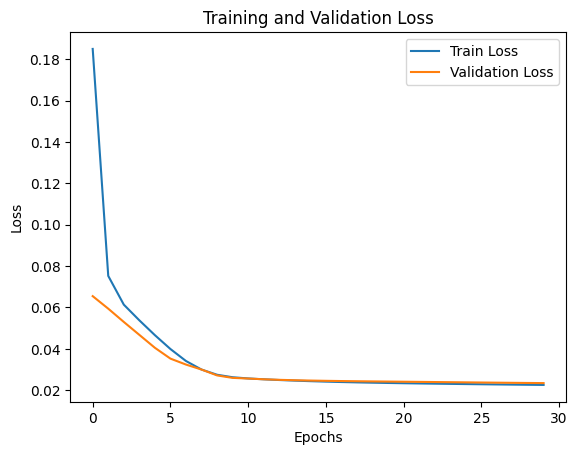

In [51]:
# 高炉模型训练
epoch_once = epoch_once_time
epoch_sum_gaolu = epoch_sum_gaolu + epoch_once
gaolu_train_loss_list,gaolu_val_loss_list = model_gaolu.my_fit(X_gaolu_train, y_gaolu_train,
                                    X_gaolu_val, y_gaolu_val, 
                                    gaolu_train_loss_list, gaolu_val_loss_list,
                                    epochs=epoch_once, 
                                    batch_size=32,
                                    lr = 0.002)

print('\nepoch_sum:',epoch_sum_gaolu)

# 绘制训练和验证损失曲线
plt.plot(gaolu_train_loss_list, label='Train Loss')
plt.plot(gaolu_val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()



RMSE:  铁口1温度: 7.8887 , SI: 0.0802 
MAPE:  铁口1温度: 0.4185% , SI: 15.4873%
MRE :  铁口1温度: 0.0042  , SI: 0.1549 
per :  铁口1温度: 0.8000  , SI: 0.7750 


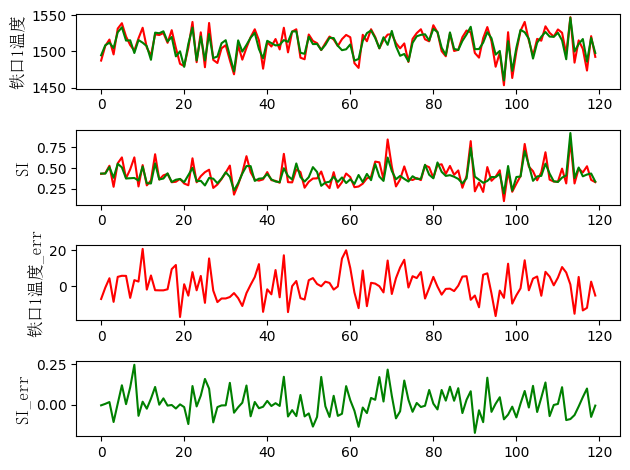

In [52]:
# 高炉模型预测
y_pred_0,y_pred_1  = model_gaolu.my_predict(X_gaolu_test)
# 计算 RMSE、MRE
y_test = y_gaolu_test
double_control_predict_result(scalers,output_term,y_test,y_pred_0,y_pred_1)


In [53]:
# 创建预测模型实例
features_size = 16
hidden_size_predict = 16
# 设置随机种子
torch.manual_seed(0)
model = MyRNNModel(features_size = features_size, 
                    hidden_size = hidden_size_predict,
                    isbidirectional=True)
epoch_sum_predict = 0
predict_train_loss_list = []
predict_val_loss_list = []


第 30/30 轮, 训练误差: 0.0348, 验证误差: 0.0371
epoch_sum: 0


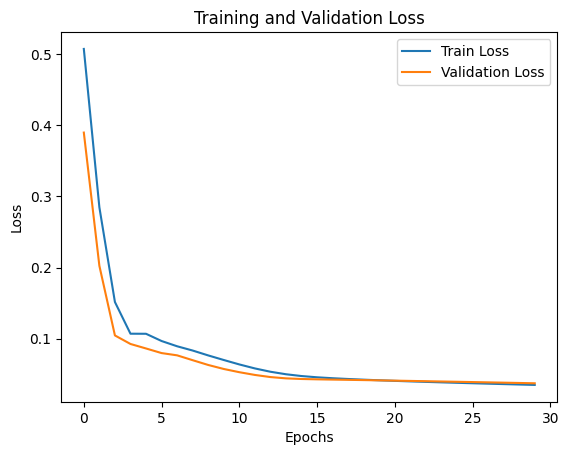

In [54]:
# 预测模型训练
epoch_once = epoch_once_time
epoch_sum = epoch_sum_predict + epoch_once
predict_train_loss_list, predict_val_loss_list = model.my_fit(X_predict_train, y_predict_train,
                                    X_predict_val, y_predict_val, 
                                    predict_train_loss_list, predict_val_loss_list,
                                    epochs=epoch_once, 
                                    batch_size=64,
                                    lr = 0.002)

print('\nepoch_sum:',epoch_sum_predict)


# 绘制训练和验证损失曲线
plt.plot(predict_train_loss_list, label='Train Loss')
plt.plot(predict_val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


RMSE:  铁口1温度: 8.8222 , SI: 0.1022 
MAPE:  铁口1温度: 0.4518% , SI: 16.8494%
MRE :  铁口1温度: 0.0045  , SI: 0.1685 
per :  铁口1温度: 0.7542  , SI: 0.7373 


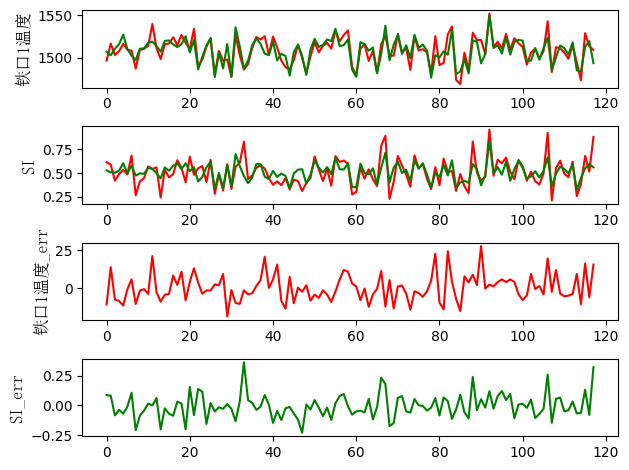

In [55]:
# 预测模型预测
y_pred_0,y_pred_1  = model.my_predict(X_predict_test)
# 计算 RMSE、MRE
y_test = y_predict_test
double_control_predict_result(scalers,output_term,y_test,y_pred_0,y_pred_1)


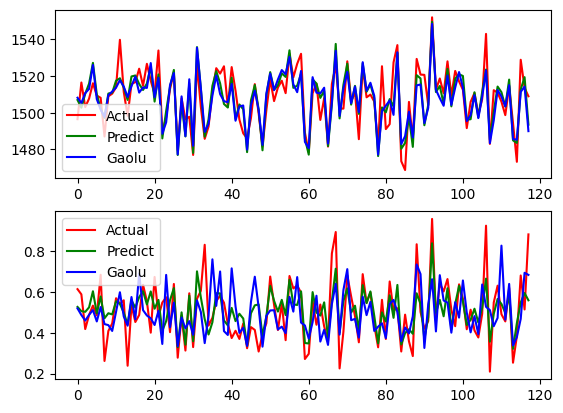

In [56]:
# 高炉、预测、原始对比
gaolu_predict_raw(scalers,output_term,model,model_gaolu,X_predict_test,y_predict_test)


In [57]:
# 自定义预测
numpy_predict = CustomPredictor_double(model,hidden_size_predict)


In [58]:
# 生成期望数据
def get_y_aim_data2222(Times):
    set_y1 = np.full(Times,1500)
    set_y1[30:] = 1525
    set_y1[60:] = 1550
    set_y1[90:] = 1475
    # set_y1[70:] = 1520
    # set_y1[90:] = 1525

    set_y2 = np.full(Times,0.40)
    set_y2[15:] = 0.50
    set_y2[45:] = 0.60
    set_y2[75:] = 0.40
    # 限制设定值在 -1 到 1 之间
    # set_y1 = np.clip(set_y1, -1, 1)
    # set_y2 = np.clip(set_y2, -1, 1)

    set_y1_trans = scalers[output_term[0]].transform(set_y1.reshape(-1,1)).flatten()
    set_y2_trans = scalers[output_term[1]].transform(set_y2.reshape(-1,1)).flatten()

    return set_y1, set_y2, set_y1_trans, set_y2_trans


In [59]:
#生成控制时域的数据格式
def generate_k_data(u1_data, u2_data, u3_data, u4_data, u5_data, u6_data, u7_data, y1_data,y2_data, num_samples, P):
    nearest_index = np.abs(y1_data - (-0.5)).argmin()
    # 生成随机索引值
    #从原有数据的randint时刻开始往下进行控制
    randint = np.random.randint(1, num_samples - 2 - P - 1)
    randint = nearest_index  # 如果你希望使用固定的值而不是随机生成
    # randint = 250  # 如果你希望使用固定的值而不是随机生成
    # print(randint)
    # 提取数据并构成 k_data
    # 第一次得到下面五个变量，固定好格式构成k_data
    u1   = u1_data[randint  :randint+2  ]
    u2   = u2_data[randint  :randint+2  ]
    u3   = u3_data[randint  :randint+2  ]
    u4   = u4_data[randint  :randint+2  ]
    u5   = u2_data[randint  :randint+2  ]
    u6   = u3_data[randint  :randint+2  ]
    u7   = u4_data[randint  :randint+2  ]
    u1_1 = u1_data[randint-1:randint+2-1]
    u2_1 = u2_data[randint-1:randint+2-1]    
    u3_1 = u3_data[randint-1:randint+2-1]
    u4_1 = u4_data[randint-1:randint+2-1]
    u5_1 = u2_data[randint-1:randint+2-1]    
    u6_1 = u3_data[randint-1:randint+2-1]
    u7_1 = u4_data[randint-1:randint+2-1]

    y1   = y1_data[randint  :randint+2  ]
    y2   = y2_data[randint  :randint+2  ]
    k_data = np.concatenate((u1, u2, u3, u4, u5, u6, u7, u1_1, u2_1, u3_1, u4_1, u5_1, u6_1, u7_1, y1, y2), axis=0)
    # print(k_data.shape)

    k_data = np.zeros_like(k_data)
    return k_data


In [60]:
# 定义单时刻的MPC问题优化
def my_MPC(k_data,params,M,P,y1_aim,y2_aim,isprint):
    h1 = 1.0
    h2 = 1.0
    lamda1 = 0.001
    lamda2 = 0.001
    lamda3 = 0.001
    lamda4 = 0.001
    y1_percent = 1.0
    y2_percent = 1.0

    # 从固定格式k_data里面读取信息
    u1   = k_data[0:2]
    u2   = k_data[2:4]
    u3   = k_data[4:6]
    u4   = k_data[6:8]
    u5   = k_data[8:10]
    u6   = k_data[10:12]
    u7   = k_data[12:14]
    u1_1 = k_data[14:16]
    u2_1 = k_data[16:18]
    u3_1 = k_data[18:20]
    u4_1 = k_data[20:22]
    u5_1 = k_data[22:24]
    u6_1 = k_data[24:26]
    u7_1 = k_data[26:28]

    y1   = k_data[28:30]
    y2   = k_data[30:32]
    # 获取猜测值[h U1 U2]
    # h, U1, U2  =params[0], params[1:M+1],params[M+1:]
    U1, U2, U3, U4, U5, U6, U7  =params[0:M], params[M:2*M],params[2*M:3*M], params[3*M:4*M], params[4*M:5*M],params[5*M:6*M], params[6*M:7*M]

    # 整理数据见   MPC推到.escel
    u1   = np.concatenate((u1[:1],U1))
    u2   = np.concatenate((u2[:1],U2))
    u3   = np.concatenate((u3[:1],U3))
    u4   = np.concatenate((u4[:1],U4))
    u5   = np.concatenate((u5[:1],U5))
    u6   = np.concatenate((u6[:1],U6))
    u7   = np.concatenate((u7[:1],U7))

    u1_1 = np.concatenate((u1_1[:2],U1[:-1]))
    u2_1 = np.concatenate((u2_1[:2],U2[:-1]))
    u3_1 = np.concatenate((u3_1[:2],U3[:-1]))
    u4_1 = np.concatenate((u4_1[:2],U4[:-1]))
    u5_1 = np.concatenate((u5_1[:2],U5[:-1]))
    u6_1 = np.concatenate((u6_1[:2],U6[:-1]))
    u7_1 = np.concatenate((u7_1[:2],U7[:-1]))

    y1   = np.concatenate((y1,np.zeros(P)))
    y2   = np.concatenate((y2,np.zeros(P)))
    y1_k = y1[1]
    y2_k = y2[1]
    # print(u1)
    # print(u2)
    # print(u1_1)
    # print(u2_1)
    # print(y1)
    # print(y2)
    # print(y1_k)    
    # print(y2_k)

    # 总共预测 P+1 次
    # 对k时刻进行预测-----1次
    for j in range(1):
        x = np.column_stack((u1[j],u2[j],u3[j],u4[j],u5[j],u6[j],u7[j],u1_1[j],u2_1[j],u3_1[j],u4_1[j],u5_1[j],u6_1[j],u7_1[j],y1[j],y2[j]))
        x = x.reshape((x.shape[0], 1, x.shape[1]))
        y1_m_k,y2_m_k = numpy_predict.predict(x)
        # y1[j+1] = y1_m_k.item()###############################是否替换不知道有没有影响？
        # y2[j+1] = y2_m_k.item()###############################
        # 在k时刻，我要先通过k-1时刻来预测出当前k时刻下的预测值。
        # 实际上，这个时候我有k时刻的真实值。
        # 但是这么做是为了能够获取我的预测值和真实值之间的误差，
        # 然后基于这个误差，通过对控制器输入的调整来预测k+1时刻，
        # 然后依次往下。因此，在k时刻，我系统的值是固定的，
        # 也就是我的真实值，所以我要把它存储到我的整体的一个序列里面。
        # 在取出当前k时刻真实值的过程中，我不能将之前预测的时候的那个
        # 预测值覆盖掉真实值。后面新预测的数值要加上前面的那一个误差
        E1_k = y1_k - y1_m_k
        E2_k = y2_k - y2_m_k

    # 对每个U对应的控制时刻进行预测-----M次
    for j in range(1,M+1):  
        x = np.column_stack((u1[j],u2[j],u3[j],u4[j],u5[j],u6[j],u7[j],u1_1[j],u2_1[j],u3_1[j],u4_1[j],u5_1[j],u6_1[j],u7_1[j],y1[j],y2[j]))
        x = x.reshape((x.shape[0], 1, x.shape[1]))
        y1_k_j,y2_k_j = numpy_predict.predict(x)
        y1[j+1] = y1_k_j.item()#将预测值作为下一步的输出值
        y2[j+1] = y2_k_j.item()

    # 对控制时域外的部分进行预测-----P-M次
    # 注意：这部分的信号是保持控制不变下进行
    for j in range(M+1,P+1):
        x = np.column_stack((u1[-1],u2[-1],u3[-1],u4[-1],u5[-1],u6[-1],u7[-1],u1_1[-1],u2_1[-1],u3_1[-1],u4_1[-1],u5_1[-1],u6_1[-1],u7_1[-1],y1[j],y2[j]))
        x = x.reshape((x.shape[0], 1, x.shape[1]))
        y1_k_j,y2_k_j = numpy_predict.predict(x)
        y1[j+1] = y1_k_j.item()#将预测值作为下一步的输出值
        y2[j+1] = y2_k_j.item()

    k_data2 = np.concatenate((u1[1:3],u2[1:3],u3[1:3],u4[1:3],u5[1:3],u6[1:3],u7[1:3],u1_1[1:3],u2_1[1:3],u3_1[1:3],u4_1[1:3],u5_1[1:3],u6_1[1:3],u7_1[1:3],y1[1:3],y2[1:3]),axis=0)


    
    # y1_aim = scalers[output_term[0]].inverse_transform(np.array(y1_aim).reshape(-1, 1)).flatten()
    # y1 = scalers[output_term[0]].inverse_transform(np.array(y1).reshape(-1, 1)).flatten()
    # y1_k = scalers[output_term[0]].inverse_transform(np.array(y1_k).reshape(-1, 1)).flatten()
    # y2_aim = scalers[output_term[1]].inverse_transform(np.array(y2_aim).reshape(-1, 1)).flatten()
    # y2 = scalers[output_term[1]].inverse_transform(np.array(y2).reshape(-1, 1)).flatten()
    # y2_k = scalers[output_term[1]].inverse_transform(np.array(y2_k).reshape(-1, 1)).flatten()
    # E1_k = scalers[output_term[0]].inverse_transform(np.array(E1_k).reshape(-1, 1)).flatten()
    # E2_k = scalers[output_term[1]].inverse_transform(np.array(E2_k).reshape(-1, 1)).flatten()
    # u1 = scalers[input_term[0]].inverse_transform(np.array(u1).reshape(-1, 1)).flatten()
    # u2 = scalers[input_term[1]].inverse_transform(np.array(u2).reshape(-1, 1)).flatten()
    # u3 = scalers[input_term[2]].inverse_transform(np.array(u3).reshape(-1, 1)).flatten()
    # u4 = scalers[input_term[3]].inverse_transform(np.array(u4).reshape(-1, 1)).flatten()


    #和获取参考轨迹
    # 一定要对照好做差的序列
    y1_r_aim  = generate_yr(y1_aim,y1_k,0.1,P+1)
    y1_r = y1_r_aim[1:] 


    y2_r_aim  = generate_yr(y2_aim,y2_k,0.1,P+1)
    y2_r = y2_r_aim[1:] 

    y1_M_k = y1[2:]
    y2_M_k = y2[2:]
    if isprint==1:

        print('y1_k',y1_k)  
        print('y1_m_k',y1_m_k)    
        print('y2_k',y2_k)  
        print('y2_m_k',y2_m_k)    

        print('temp:')
        print('y1_aim',y1_aim)
        print('y1_r_aim',y1_r_aim)
        print('  ')
        print('y1_r',y1_r)
        print('y1_M_k+h1*E1_k',y1_M_k+h1*E1_k)
        print('  ')
        print('y1',y1)
        print('h*E1_k',h1*E1_k)

        print('Si_percent:')
        print('y2_aim',y2_aim)
        print('y2_r_aim',y2_r_aim)
        print('y2_r',y2_r)
        print('y2_M_k+h2*E2_k',y2_M_k+h2*E2_k)

        print('y2',y2)
        print('h*E2_k',h2*E2_k)

        print('u:')
        print(u1)
        print(u2)
        print(u3)
        print(u4)
        
    # 计算mse
    # lamda1太大的话会导致y1_r和y1_M_k的误差加大*****************导致超调的原因\与目标值之间存在间隙
    
    # if np.abs(y1_aim-y1_k)<0.0001 and np.abs(y2_aim-y2_k)<0.0001:
    #     lamda1 = 1

    y1_err = y1_percent*np.sum(np.fabs(y1_r-(y1_M_k+h1*E1_k))) 
    y2_err = y2_percent*np.sum(np.fabs(y2_r-(y2_M_k+h2*E2_k))) 
    u1_power = lamda1*np.sum((np.fabs(np.diff(u1))))
    u2_power = lamda2*np.sum((np.fabs(np.diff(u2))))
    u3_power = lamda3*np.sum((np.fabs(np.diff(u3))))
    u4_power = lamda4*np.sum((np.fabs(np.diff(u4))))
    u5_power = lamda2*np.sum((np.fabs(np.diff(u5))))
    u6_power = lamda3*np.sum((np.fabs(np.diff(u6))))
    u7_power = lamda4*np.sum((np.fabs(np.diff(u7))))

    mse = (0
            # +loss_function(y1_r, y1_M_k+h*E1_k, weights)
            # +loss_function(y2_r, y2_M_k+h*E2_k, weights)
            # +(np.abs(y1_aim-y1_k)**2+np.abs(y2_aim-y2_k)**2)*P*2000
            # +np.sum((y1_r-y1_M_k-h*E1_k)**2 + (y2_r-y2_M_k-h*E2_k)**2)
            +y1_err
            +y2_err
            +u1_power
            +u2_power
            +u3_power
            +u4_power
            +u5_power
            +u6_power
            +u7_power

            )
    
    # print('mse {:.7f}'.format(mse))
    if isprint==1:
        print('mse {:.7f}'.format(mse))
        print('1111 {:.7f}'.format(y1_err))
        print('2222 {:.7f}'.format(y2_err))
        print('1111 {:.7f}'.format(u1_power))
        print('2222 {:.7f}'.format(u2_power))
        print('3333 {:.7f}'.format(u3_power))
        print('4444 {:.7f}'.format(u4_power))



    return mse , k_data2, E1_k*h1, E2_k*h2


In [61]:
Times = 100
iscontrol = True
# iscontrol = False


In [62]:
# 对未来Times周期预测控制
max_control = 1.0
# 期望设定值
set_y1, set_y2, set_y1_trans, set_y2_trans = get_y_aim_data2222(Times)

# MPC参数
P = 4  # 预测时域长度  增大P能平稳些
M = 2  # 控制时域长度
#生成控制时域的数据格式
k_data = generate_k_data(u1_data, u2_data, u3_data, u4_data, u5_data, u6_data, u7_data, 
                        y1_data, y2_data, num_samples, P)

# MPC控制循环   迭代的只有：k_data
all_pred_y1 = []
all_pred_y2 = []
all_pred_u1 = []
all_pred_u2 = []
all_pred_u3 = []
all_pred_u4 = []
all_pred_u5 = []
all_pred_u6 = []
all_pred_u7 = []
all_update_loss = []
# MPC控制循环40
for k in range(Times):
    if iscontrol == False:
        break
    print(f"这是对第{k}时刻的最优U1、U2输入求解")
    # print('y1_aim  y2_aim',set_y1[k],set_y2[k])
    # 定义优化目标函数
    def objective_function(params, *k_data):
        mse, k_data2, E1_k_0, E2_k_0 = my_MPC(k_data=k_data[0], params=params, 
                                M=M, P=P, 
                                y1_aim = set_y1_trans[k], y2_aim = set_y2_trans[k],
                                isprint = 0) 
        return mse
    
    # 初始猜测值[h U1 U2]
    params = np.concatenate([np.ones(M), np.ones(M),np.ones(M), np.ones(M), np.ones(M),np.ones(M), np.ones(M)])
    # 定义参数的上下限  
    bounds = [(-max_control, max_control) for _ in range(7 * M)]
    # 设置退出条件
    exit_conditions = {'maxiter': 1000}  # 您可以根据需要调整容差

    # 进行优化
    result = minimize(objective_function, params, method='L-BFGS-B', 
                    bounds=bounds, args=k_data)#args传进来的是一个元组
    

    optimized_U1, optimized_U2, \
        optimized_U3, optimized_U4, \
        optimized_U5, optimized_U6, \
        optimized_U7 = result.x[0:M], result.x[M:2*M], result.x[2*M:3*M], result.x[3*M:4*M], result.x[4*M:5*M], result.x[5*M:6*M], result.x[6*M:7*M]


    # 获取当前时刻下，在最优的U1、U2下的响应    
    u1_k = optimized_U1[0]
    u2_k = optimized_U2[0]
    u3_k = optimized_U3[0]
    u4_k = optimized_U4[0]
    u5_k = optimized_U5[0]
    u6_k = optimized_U6[0]
    u7_k = optimized_U7[0]
    u1_k_1 = k_data[15]
    u2_k_1 = k_data[17]
    u3_k_1 = k_data[19]
    u4_k_1 = k_data[21]
    u5_k_1 = k_data[23]
    u6_k_1 = k_data[25]
    u7_k_1 = k_data[27]
    y1_k = k_data[29] 
    y2_k = k_data[31] 
    

    
    x = np.column_stack((u1_k,u2_k,u3_k,u4_k,u5_k,u6_k,u7_k,u1_k_1,u2_k_1,u3_k_1,u4_k_1,u5_k_1,u6_k_1,u7_k_1,y1_k,y2_k))
    x = x.reshape((x.shape[0], 1, x.shape[1]))
    y1_pred0, y2_pred0 = model.my_predict(x)
    y1_pred, y2_pred = model_gaolu.my_predict(x)
    


    # 获取当前时刻下，在最优的U1、U2下的响应
    params = np.concatenate((optimized_U1,optimized_U2,optimized_U3,optimized_U4,optimized_U5,optimized_U6,optimized_U7),axis=0)
    mse, k_data2, E1_k_0, E2_k_0 =my_MPC(k_data=k_data,params=params,
                            M=M,P=P, 
                            y1_aim = set_y1_trans[k], y2_aim = set_y2_trans[k],
                            isprint = 0) 
    
    print(  '1设定',set_y1_trans[k].round(4),\
            '预测',y1_pred0.round(4),\
            '高炉', y1_pred.round(4),\
            '高炉与设定误差',(set_y1_trans[k]-y1_pred).round(4),(set_y1_trans[k]-y1_pred).round(4)/d_temp,\
            '模型误差',(y1_pred0 - y1_pred).round(4),\
            '校正值',E1_k_0.round(4))
    print(  '2设定',set_y2_trans[k].round(4),\
            '预测',y2_pred0.round(4),\
            '高炉', y2_pred.round(4),\
            '高炉与设定误差',(set_y2_trans[k]-y2_pred).round(4),(set_y2_trans[k]-y2_pred).round(4)/d_yuansu,\
            '模型误差',(y2_pred0 - y2_pred).round(4),\
            '校正值',E2_k_0.round(4))
    #自适应调控预测模型
    x_batch = x
    y_batch = np.column_stack((y1_pred,y2_pred))
    loss = model.my_fit2(x_batch, y_batch)
    all_update_loss.append(loss)

    #

    all_pred_y1.append(y1_pred)
    all_pred_y2.append(y2_pred)
    all_pred_u1.append(u1_k)
    all_pred_u2.append(u2_k)
    all_pred_u3.append(u3_k)
    all_pred_u4.append(u4_k)
    all_pred_u5.append(u5_k)
    all_pred_u6.append(u6_k)
    all_pred_u7.append(u7_k)
    k_data2[29] = y1_pred
    k_data2[31] = y2_pred
    k_data = k_data2
    # 进入下一时刻，更新预测时域、控制时域，即k_data




这是对第0时刻的最优U1、U2输入求解


1设定 0.0547 预测 [0.1928] 高炉 [0.1391] 高炉与设定误差 [-0.0844] [-5.59886167] 模型误差 [0.0537] 校正值 [-0.1415]
2设定 -0.6471 预测 [-0.3524] 高炉 [0.0391] 高炉与设定误差 [-0.6862] [-0.2942816] 模型误差 [-0.3914] 校正值 [0.1077]
这是对第1时刻的最优U1、U2输入求解


C:\Users\haokw\AppData\Local\Temp\ipykernel_25608\3143785527.py:119: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k_data2[29] = y1_pred
C:\Users\haokw\AppData\Local\Temp\ipykernel_25608\3143785527.py:120: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k_data2[31] = y2_pred


1设定 0.0547 预测 [0.1935] 高炉 [0.2742] 高炉与设定误差 [-0.2195] [-14.56102123] 模型误差 [-0.0807] 校正值 [-0.0508]
2设定 -0.6471 预测 [-0.4766] 高炉 [-0.0887] 高炉与设定误差 [-0.5584] [-0.23947367] 模型误差 [-0.3879] 校正值 [0.3758]
这是对第2时刻的最优U1、U2输入求解
1设定 0.0547 预测 [0.2213] 高炉 [0.3452] 高炉与设定误差 [-0.2904] [-19.26433002] 模型误差 [-0.1238] 校正值 [0.0637]
2设定 -0.6471 预测 [-0.4844] 高炉 [-0.0339] 高炉与设定误差 [-0.6132] [-0.26297504] 模型误差 [-0.4505] 校正值 [0.3628]
这是对第3时刻的最优U1、U2输入求解
1设定 0.0547 预测 [0.3142] 高炉 [0.221] 高炉与设定误差 [-0.1662] [-11.02524659] 模型误差 [0.0932] 校正值 [0.1082]
2设定 -0.6471 预测 [-0.2507] 高炉 [-0.2093] 高炉与设定误差 [-0.4378] [-0.18775354] 模型误差 [-0.0414] 校正值 [0.4264]
这是对第4时刻的最优U1、U2输入求解
1设定 0.0547 预测 [0.1111] 高炉 [0.1741] 高炉与设定误差 [-0.1193] [-7.91403096] 模型误差 [-0.0629] 校正值 [-0.0675]
2设定 -0.6471 预测 [-0.4714] 高炉 [-0.2871] 高炉与设定误差 [-0.36] [-0.15438848] 模型误差 [-0.1844] 校正值 [0.0305]
这是对第5时刻的最优U1、U2输入求解
1设定 0.0547 预测 [0.1613] 高炉 [0.1313] 高炉与设定误差 [-0.0766] [-5.08143145] 模型误差 [0.0299] 校正值 [0.0431]
2设定 -0.6471 预测 [-0.4475] 高炉 [-0.4097] 高炉与设定误差 [-0.237

上线分别是：[2.00736825e+04 2.48731508e-04]、[3.37254652e+01 3.41094835e-06]、[ 4.32087465e-01 -2.78527280e-04]、[236.915       36.54472222]
平均误差 21.5492
平均误差 0.1996


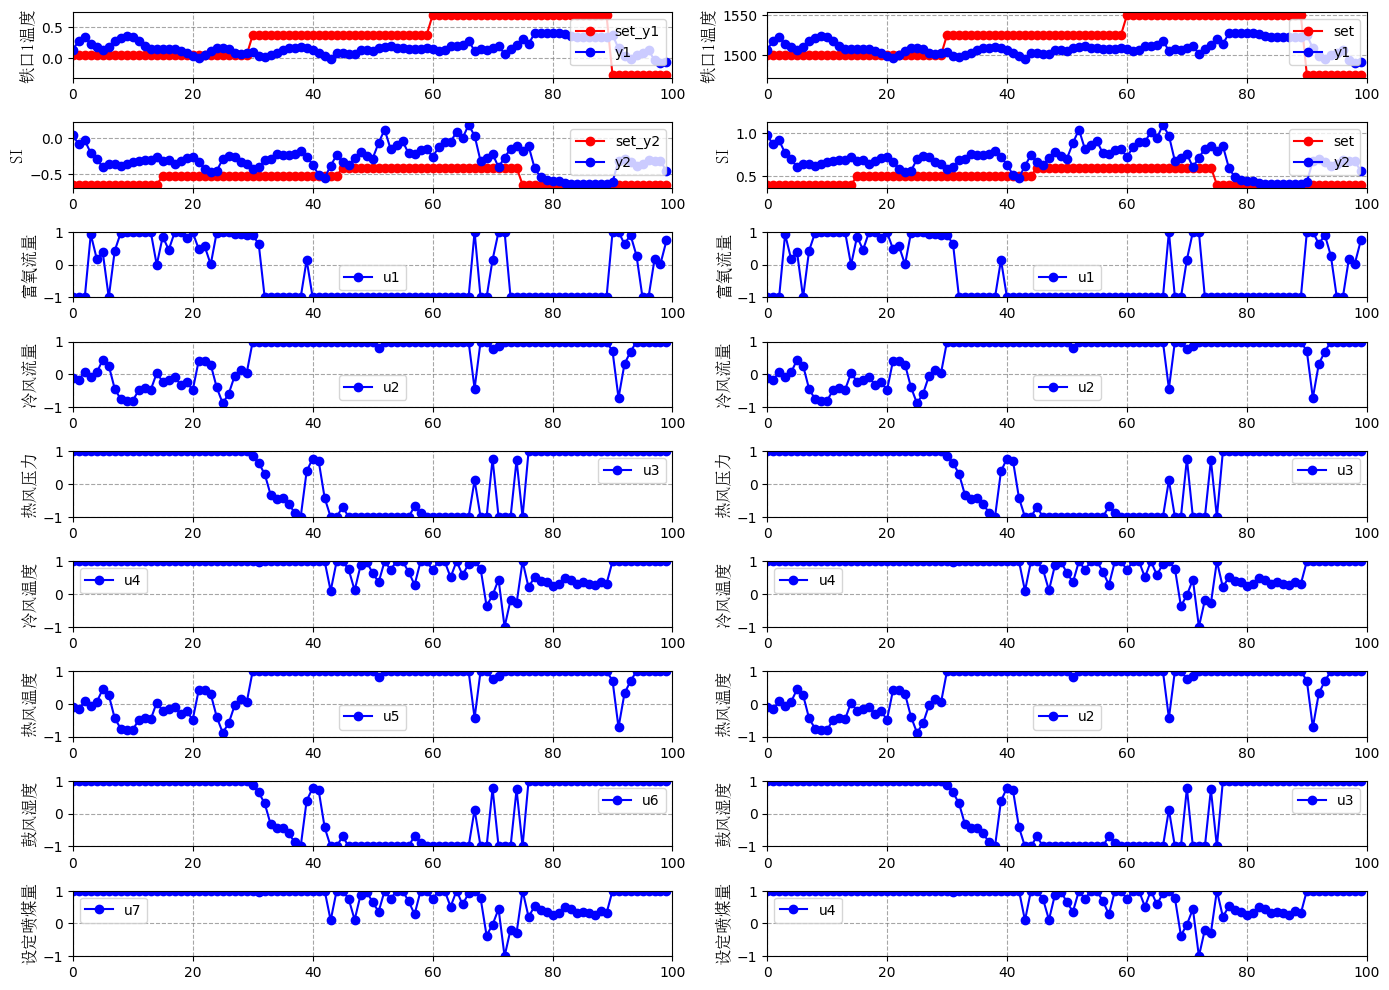

In [63]:
# 数据转换、
data_tranform_plot(scalers,Times ,max_control,
                        output_term,input_term,
                        set_y1,set_y2,set_y1_trans,set_y2_trans,
                        all_pred_y1, all_pred_y2,
                        all_pred_u1,
                        all_pred_u2,
                        all_pred_u3,
                        all_pred_u4)
